In [5]:
from sklearn import metrics
import pandas as pd
import numpy as np
import scanpy as sc
from matplotlib import pyplot as plt 

from numpy.random import default_rng
rng = default_rng(seed=1234)

# Data

In [30]:
beta_sce = sc.read_h5ad("/home/ubuntu/data/beta_sce.h5ad")

In [31]:
beta_sce.shape

(575, 40737)

In [32]:
beta_sce.uns

{'X_name': 'logcounts'}

In [33]:
beta_sce = beta_sce[beta_sce.obs.developmental_stage_ch1 != "NA", :].copy()
beta_sce.obs.developmental_stage_ch1

bE17.5_1_01    E17.5
bE17.5_1_02    E17.5
bE17.5_1_03    E17.5
bE17.5_1_04    E17.5
bE17.5_1_05    E17.5
               ...  
bP9_2_26          P9
bP9_4_13          P9
bP15_1_21        P15
bP15_1_22        P15
bP60_1_40        P60
Name: developmental_stage_ch1, Length: 423, dtype: category
Categories (7, object): ['E17.5', 'P0', 'P3', 'P9', 'P15', 'P18', 'P60']

In [34]:
ordinal_labels = {"E17.5": 0, "P0": 1, "P3": 2, "P9": 3, "P15": 4, "P18": 5, "P60": 6}
beta_sce.obs["ordinal_label"] = beta_sce.obs.developmental_stage_ch1.map(ordinal_labels)

# Run PyPsupertime

In [10]:
from pypsupertime import Psupertime
from pypsupertime.preprocessing import transform_labels

psuper = Psupertime(preprocessing_params={"scale": True, "normalize": False, "log": False, "smooth": False, "select_genes": "hvg"},
                    n_jobs=5,
                    n_batches=1)

anndata = psuper.run(beta_sce.copy(), "ordinal_label", copy=True)

Input Data: n_genes=40737, n_cells=423
Preprocessing: done. mode='hvg', n_genes=4131, n_cells=423
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.503546.02, n_genes=72
Total elapsed time:  0:07:27.294604


Best idx: 26 Best Score: 0.5554621848739496 Best Lambda: 0.0021544346900318847 Scores std: 0.14733996360947282
1SE idx: 17 1SE Score: 0.4443697478991597 1SE Lambda: 0.0180472176682717


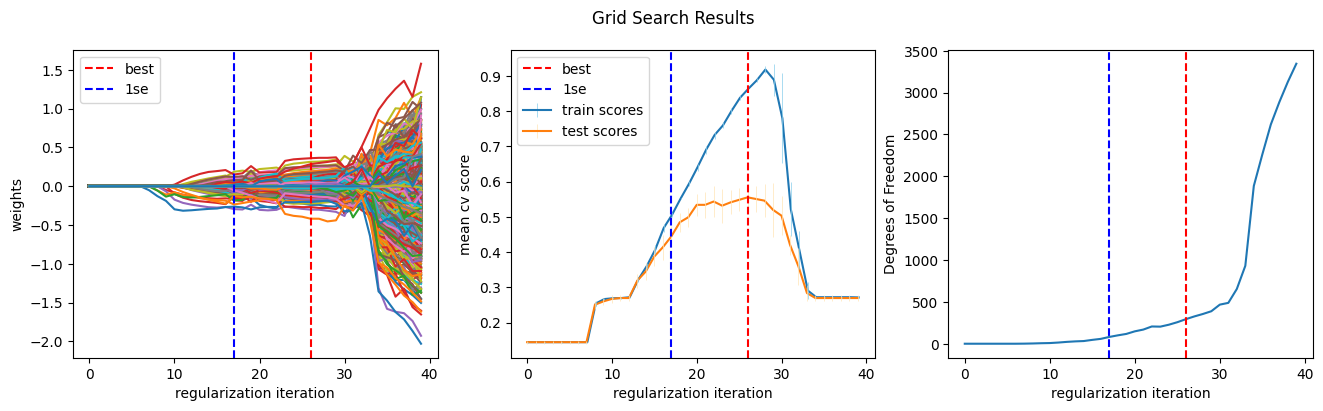

In [11]:
_ = psuper.plot_grid_search()

In [107]:
#psuper.refit_and_predict(beta_copy, "index", 25)

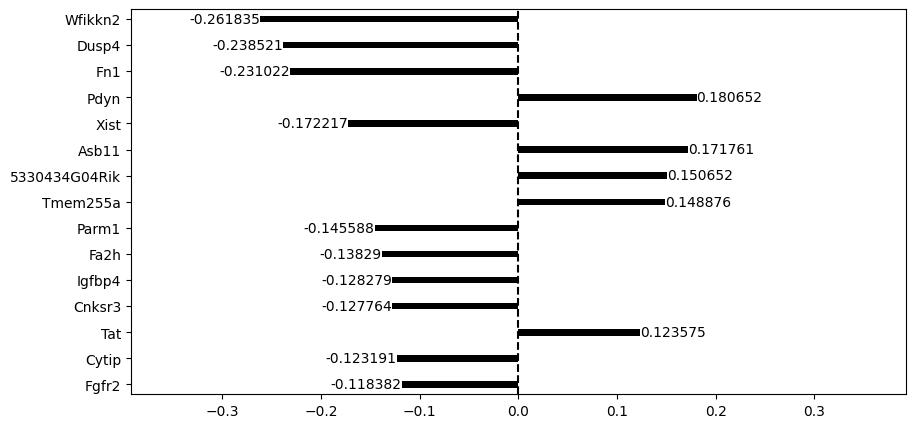

In [12]:
_ = psuper.plot_identified_gene_coefficients(anndata, n_top=15, figsize=(10,5))

Model Degrees of freedom 72
Accuracy: 0.5035460992907801
Balanced accuracy: 0.4619400352733686
Mean absolute delta: 0.6548583993481952


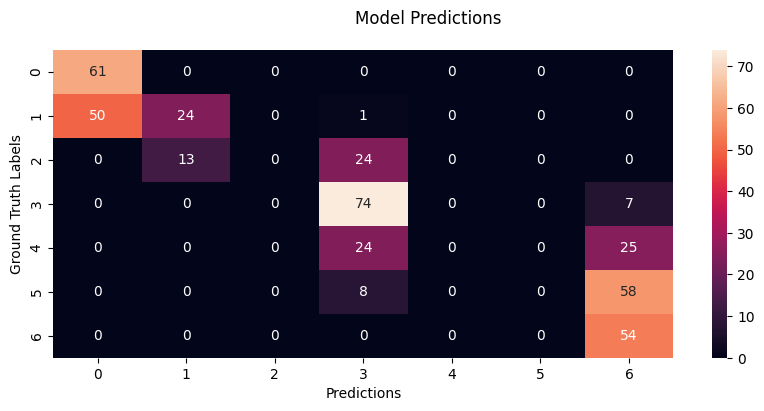

In [13]:
_ = psuper.plot_model_perf(train=(anndata.X, anndata.obs.ordinal_label))

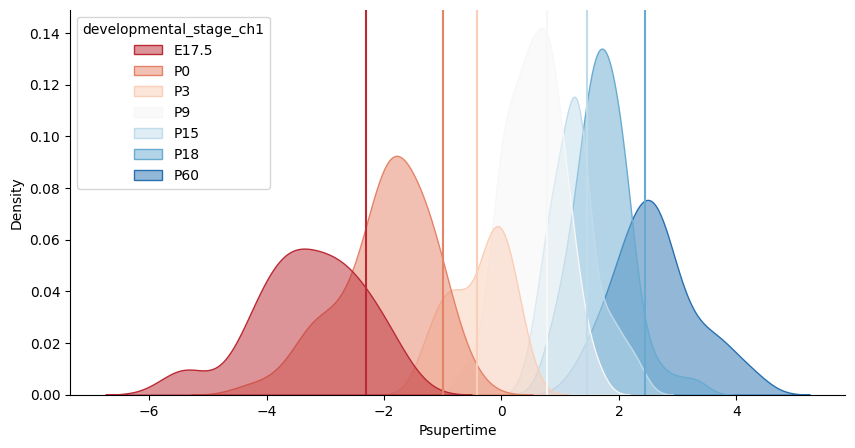

In [14]:
fig = psuper.plot_labels_over_psupertime(anndata, "developmental_stage_ch1")
#fig.get_axes()[0].set_xlim((-500,500))

In [15]:
from sklearn import metrics
print("Abs Error:", metrics.mean_absolute_error(anndata.obs.ordinal_label, anndata.obs.predicted_label))
print("Balanced Acc:", metrics.balanced_accuracy_score(anndata.obs.ordinal_label, anndata.obs.predicted_label))

n_genes_start = 26178
dof =  np.count_nonzero(psuper.model.coef_)
print("DoF (sparsity): %s (%s)" % (dof, 1 - (dof / n_genes_start) ))

Abs Error: 0.6099290780141844
Balanced Acc: 0.4619400352733686
DoF (sparsity): 72 (0.9972495988998396)


## Repeat on Different Seeds

In [17]:
seeds = [257, 6341, 5654, 452, 39]
acc_best = []
acc_1se = []
bacc_best = []
bacc_1se = []
dof_best = []
dof_1se = []

In [18]:
from pypsupertime import Psupertime
from pypsupertime.preprocessing import transform_labels
import scanpy as sc

for i, s in enumerate(seeds):
    print("Iter %i, seed %i" % (i, s))
    
    psuper = Psupertime(preprocessing_params={"scale": True, "normalize": False, "log": False, "smooth": False, "select_genes": "hvg"},
                    n_jobs=5,
                    n_batches=1,
                    random_state=s)
    adata = psuper.run(beta_sce.copy(), "ordinal_label")

    acc_1se.append(metrics.accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    bacc_1se.append(metrics.balanced_accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    dof =  np.count_nonzero(psuper.model.coef_)
    dof_1se.append(dof)

    # refit and predict best model
    psuper.refit_and_predict(adata, "best")
    acc_best.append(metrics.accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    bacc_best.append(metrics.balanced_accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    dof =  np.count_nonzero(psuper.model.coef_)
    dof_best.append(dof)

Iter 0, seed 257
Input Data: n_genes=40737, n_cells=423
Preprocessing: done. mode='hvg', n_genes=4131, n_cells=423
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.498818.02, n_genes=68
Total elapsed time:  0:08:16.516408
Input Data: n_genes=4131, n_cells=423
Refit on all data: done. accuracy=0.678487.02, n_genes=177
Iter 1, seed 6341
Input Data: n_genes=40737, n_cells=423
Preprocessing: done. mode='hvg', n_genes=4131, n_cells=423
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.503546.02, n_genes=70
Total elapsed time:  0:08:58.596531
Input Data: n_genes=4131, n_cells=423
Refit on all data: done. accuracy=0.903073.02, n_genes=402
Iter 2, seed 5654
Input Data: n_genes=40737, n_cells=423
Preprocessing: done. mode='hvg', n_genes=4131, n_cells=423
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.449173.02, n_genes=60
Total elapsed time:  0:08:07.289203
Inp

In [27]:
import numpy as np

num_input_genes = 40737
hvg = 4131

print("1se model")
print("accuracy: %s (%s)" % (np.mean(acc_1se), np.std(acc_1se)))
print("balanced accuracy: %s (%s)" % (np.mean(bacc_1se), np.std(bacc_1se)))
print("dof: %s (%s)" % (np.mean(dof_1se) , np.std(dof_1se)))
print("Sparsity (all genes): %s (%s)" % (1 - (np.mean(dof_1se) / num_input_genes), np.std(dof_1se) / num_input_genes))
print("Sparsity (hvg): %s (%s)" % (1 - (np.mean(dof_1se) / hvg), np.std(dof_1se) / hvg))
print()

print("best model")
print("accuracy: %s (%s)" % (np.mean(acc_best), np.std(acc_best)))
print("balanced accuracy: %s (%s)" % (np.mean(bacc_best), np.std(bacc_best)))
print("dof: %s (%s)" % (np.mean(dof_best) , np.std(dof_best)))
print("Sparsity (all genes): %s (%s)" % (1 - (np.mean(dof_best) / num_input_genes), np.std(dof_best) / num_input_genes))
print("Sparsity (hvg): %s (%s)" % (1 - (np.mean(dof_best) / hvg), np.std(dof_best) / hvg))

1se model
accuracy: 0.4912529550827423 (0.02121872876814834)
balanced accuracy: 0.45211715384392975 (0.016513352351884503)
dof: 66.8 (3.54400902933387)
Sparsity (all genes): 0.9983602130741095 (8.699730047214743e-05)
Sparsity (hvg): 0.9838295812152021 (0.0008579058410394263)

best model
accuracy: 0.8132387706855791 (0.0841155880598449)
balanced accuracy: 0.7539950679542516 (0.09126111482511459)
dof: 339.6 (119.12447271656652)
Sparsity (all genes): 0.9916635982031078 (0.002924232828057209)
Sparsity (hvg): 0.9177923021060276 (0.02883671573869923)


## Repeat on Different Seeds (all Genes)

In [28]:
seeds = [25, 341, 654, 2452, 89]
acc_best = []
acc_1se = []
bacc_best = []
bacc_1se = []
dof_best = []
dof_1se = []

In [35]:
from pypsupertime import Psupertime
from pypsupertime.preprocessing import transform_labels
import scanpy as sc

for i, s in enumerate(seeds):
    print("Iter %i, seed %i" % (i, s))
    
    psuper = Psupertime(preprocessing_params={"scale": True, "normalize": False, "log": False, "smooth": False, "select_genes": "all"},
                    n_jobs=5,
                    n_batches=1,
                    random_state=s)
    adata = psuper.run(beta_sce.copy(), "ordinal_label")

    acc_1se.append(metrics.accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    bacc_1se.append(metrics.balanced_accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    dof =  np.count_nonzero(psuper.model.coef_)
    dof_1se.append(dof)

    # refit and predict best model
    psuper.refit_and_predict(adata, "best")
    acc_best.append(metrics.accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    bacc_best.append(metrics.balanced_accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    dof =  np.count_nonzero(psuper.model.coef_)
    dof_best.append(dof)

Iter 0, seed 25
Input Data: n_genes=40737, n_cells=423
Preprocessing: done. mode='all', n_genes=19621, n_cells=423
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.472813.02, n_genes=59
Total elapsed time:  0:47:34.299305
Input Data: n_genes=19621, n_cells=423
Refit on all data: done. accuracy=0.458629.02, n_genes=141
Iter 1, seed 341
Input Data: n_genes=40737, n_cells=423
Preprocessing: done. mode='all', n_genes=19621, n_cells=423
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.550827.02, n_genes=99
Total elapsed time:  0:49:06.233932
Input Data: n_genes=19621, n_cells=423
Refit on all data: done. accuracy=0.513002.02, n_genes=139
Iter 2, seed 654
Input Data: n_genes=40737, n_cells=423
Preprocessing: done. mode='all', n_genes=19621, n_cells=423
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.432624.02, n_genes=30
Total elapsed time:  0:41:21.355524
I

In [37]:
import numpy as np

def latex_tabular_fmt(acc, dof, n):
    acc_mean = np.round(np.mean(acc) * 100, 2)
    sparsity_mean = np.round((1 - (np.mean(dof) / n)) * 100, 2)
    acc_std = np.round(np.std(acc) * 100, 1)
    sparsity_std = np.round((np.std(dof) / n) * 100, 1)

    latex_template = "$%s \\pm %s$  &  $%s \\pm %s$"
    return latex_template % (acc_mean, acc_std, sparsity_mean, sparsity_std)

num_input_genes = 19621

print("1se model")
print("accuracy: %s (%s)" % (np.mean(acc_1se), np.std(acc_1se)))
print("balanced accuracy: %s (%s)" % (np.mean(bacc_1se), np.std(bacc_1se)))
print("dof: %s (%s)" % (np.mean(dof_1se) , np.std(dof_1se)))
print("Sparsity (all genes): %s (%s)" % (1 - (np.mean(dof_1se) / num_input_genes), np.std(dof_1se) / num_input_genes))
print("LATEX: accuracy & sparsity \\\\")
print(latex_tabular_fmt(acc_1se, dof_1se, num_input_genes))
print()

print("best model")
print("accuracy: %s (%s)" % (np.mean(acc_best), np.std(acc_best)))
print("balanced accuracy: %s (%s)" % (np.mean(bacc_best), np.std(bacc_best)))
print("dof: %s (%s)" % (np.mean(dof_best) , np.std(dof_best)))
print("Sparsity (all genes): %s (%s)" % (1 - (np.mean(dof_best) / num_input_genes), np.std(dof_best) / num_input_genes))
print("LATEX: accuracy & sparsity \\\\")
print(latex_tabular_fmt(acc_best, dof_best, num_input_genes))


1se model
accuracy: 0.46903073286052016 (0.04301301339212921)
balanced accuracy: 0.4347776174442841 (0.03549124076696079)
dof: 49.8 (26.9918506219933)
Sparsity (all genes): 0.9974619030630447 (0.0013756613129806484)
LATEX: accuracy & sparsity \\
$46.9 \pm 4.3$  &  $99.75 \pm 0.1$

best model
accuracy: 0.4973995271867612 (0.026094836362263115)
balanced accuracy: 0.4569575116241783 (0.021435478945732226)
dof: 114.4 (21.010473578670233)
Sparsity (all genes): 0.9941695122572753 (0.0010708156352209487)
LATEX: accuracy & sparsity \\
$49.74 \pm 2.6$  &  $99.42 \pm 0.1$
